<a href="https://colab.research.google.com/github/learqt/Keras-GAN/blob/master/WGAN_GP_Bac_%C3%A0_sable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Générer des fausses time series via WGAN-GP ( Wasserstein GAN - Gradient Penality)

In [0]:
#Packages
import os
import numpy as np
import pandas as pd
import argparse
from sklearn.preprocessing import OneHotEncoder
import keras 
import numpy as np 
import time
import warnings
import matplotlib.pyplot as plt
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
import tensorflow as tf
from keras import backend as K

from keras.models import Sequential,Model
from keras.layers import Dense, Activation,Input,Reshape
from keras import optimizers
from keras.layers import Conv1D
from keras.layers import MaxPooling1D,Flatten
from keras.layers import LeakyReLU,BatchNormalization,UpSampling1D
from keras.optimizers import RMSprop
from functools import partial
from keras.layers.merge import _Merge
%tensorflow_version 2.x

In [236]:
#Directory
cwd=os.getcwd()
cwd

'/content'

In [237]:
!pip install Keras==2.2.4
!pip install tensorflow==1.15.2

In [238]:
cwd=os.getcwd()
cwd

'/content'

In [0]:
#On utilise les données VIX
my_data = pd.read_csv(cwd + '/vixcurrent.csv', header=1, index_col=0)
vix_data = my_data.loc[:, 'VIX Close']
vix_data=vix_data.pct_change()
vix_data_arr = np.array((vix_data))

In [240]:
np.shape(vix_data_arr)

(3862,)

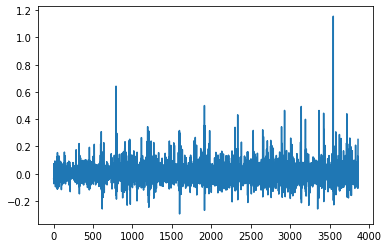

In [241]:
#Graphs
plt.plot(vix_data_arr)

Etapes d'WGAN-GP


In [301]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1,1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.img_rows = 99
        self.img_cols = 30
        #self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols)#,self.channels) #add channels ???
        self.latent_dim = 50

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(50,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        # define model
        model= Sequential() 
       
        model.add(Dense(100,input_dim=self.latent_dim)) #diff between input_shape and input_dim
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        model.add((Reshape((100,1))))

        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add (BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling1D())
        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add (BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling1D())
        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add (BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling1D())
        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add (BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        model.add(Flatten())

        model.add(Dense(100))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        model.summary()


        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model= Sequential() 
        model.add((Reshape((99,30),input_shape=self.img_shape)))

        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())

        model.add(Dense(50))
        model.add (BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(15))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size, sample_interval=50):

        #Load the dataset
        my_data = pd.read_csv(cwd + '/vixcurrent.csv', header=1, index_col=0)
        vix_data = my_data.loc[:, 'VIX Close']
        vix_data=vix_data.pct_change() #transform in daily return
        vix_data_arr = np.array((vix_data))

        X = np.array([vix_data_arr[30*k:30 + 30*k] for k in range(0,int( vix_data.size/30))]) #shape:(99,30) --> sample of 30 days
        X=X.astype(np.float32)
        X_train = mm_scaler.fit_transform(X).reshape(-1, 1)
        X_train = np.expand_dims(X_train)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            #if epoch % sample_interval == 0:
                #self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 1

        #fig, axs = plt.subplots(r, c)
        #cnt = 0
        #for i in range(r):
            #for j in range(c):
                #axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                #axs[i,j].axis('off')
               # cnt += 1
        #fig.savefig("images/mnist_%d.png" % epoch)
        #plt.close()


if __name__ == '__main__':
    wgan = WGANGP()
    wgan.train(epochs=300, batch_size=(64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_236 (Dense)            (None, 100)               5100      
_________________________________________________________________
batch_normalization_515 (Bat (None, 100)               400       
_________________________________________________________________
leaky_re_lu_517 (LeakyReLU)  (None, 100)               0         
_________________________________________________________________
reshape_92 (Reshape)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 100, 32)           128       
_________________________________________________________________
batch_normalization_516 (Bat (None, 100, 32)           128       
_________________________________________________________________
leaky_re_lu_518 (LeakyReLU)  (None, 100, 32)           0         
__________

ValueError: ignored